# Introduction

Image classification is a key task in computer vision, where the goal is to assign labels to images based on their content. Convolutional Neural Networks (CNNs) have emerged as the state-of-the-art approach, excelling in learning spatial hierarchies and features through convolution operations. This capability allows them to effectively recognize complex patterns and distinguish between different objects in images.

This project applies CNNs to classify images from the CIFAR-10 dataset, which contains 60,000 32x32 color images in 10 categories, such as airplanes, cars, and dogs. Widely used in research, CIFAR-10 offers a manageable yet challenging benchmark for evaluating image classification models.

CNNs have consistently outperformed traditional machine learning models in image recognition tasks (Wu, Liu, & Liu, 2019), thanks to their unique structural features that are particularly effective for solving image-related challenges.


### CIFAR-10 Dataset

The **CIFAR-10** dataset is a widely used collection of images in machine learning and computer vision, primarily employed for image classification and recognition tasks. It consists of 60,000 color images of size **32x32 pixels**, divided into **10 classes**, with each class containing 6,000 images. These classes represent a range of objects, including vehicles, animals, and other everyday items. The 10 classes are:

1. Airplane  
2. Automobile  
3. Bird  
4. Cat  
5. Deer  
6. Dog  
7. Frog  
8. Horse  
9. Ship  
10. Truck

Split into **50,000 training images** and **10,000 testing images**, each image is labeled according to one of the 10 classes.

Introduced by the **Canadian Institute for Advanced Research (CIFAR)** and developed by researchers at the **University of Toronto**, the dataset was released in **2009** alongside the CIFAR-100 dataset. It was designed to be small enough for machine learning algorithms to handle computationally while still providing a challenging benchmark for image classification tasks.

For this project, **Keras**, a deep learning framework, is being used to load and preprocess the CIFAR-10 dataset, making it easy to train and evaluate image classification models.

In [1]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Exploratory Data Analysis

#### Shape:

In [2]:
print("Training data:", X_train.shape)
print("Training labels:", y_train.shape)
print("Testing data:", X_test.shape)
print("Testing labels", y_test.shape)

Training data: (50000, 32, 32, 3)
Training labels: (50000, 1)
Testing data: (10000, 32, 32, 3)
Testing labels (10000, 1)


#### Distribution:

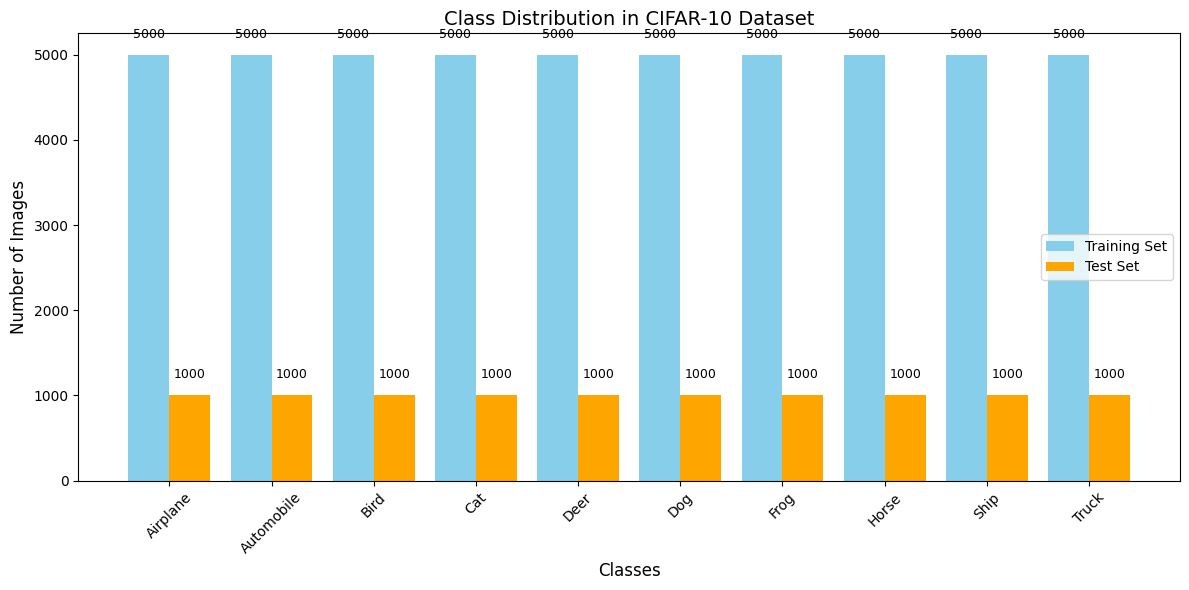

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to calculate class distribution
def get_class_distribution(y_data):
    unique, counts = np.unique(y_data, return_counts=True)
    return dict(zip(unique, counts))

# Get class distribution for training and testing sets
train_distribution = get_class_distribution(y_train)
test_distribution = get_class_distribution(y_test)

# Convert to lists for plotting
train_counts = [train_distribution[i] for i in range(10)]
test_counts = [test_distribution[i] for i in range(10)]

# Plotting
x = np.arange(len(class_names))  # Class indices
width = 0.4  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))
train_bars = ax.bar(x - width/2, train_counts, width, label='Training Set', color='skyblue')
test_bars = ax.bar(x + width/2, test_counts, width, label='Test Set', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Class Distribution in CIFAR-10 Dataset', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, fontsize=10)
ax.legend()

# Display counts on top of the bars
for bar in train_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 200, int(yval), ha='center', fontsize=9)
for bar in test_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 200, int(yval), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


We can see that there is even distribution of each class for both training and test sets.


#### Images:

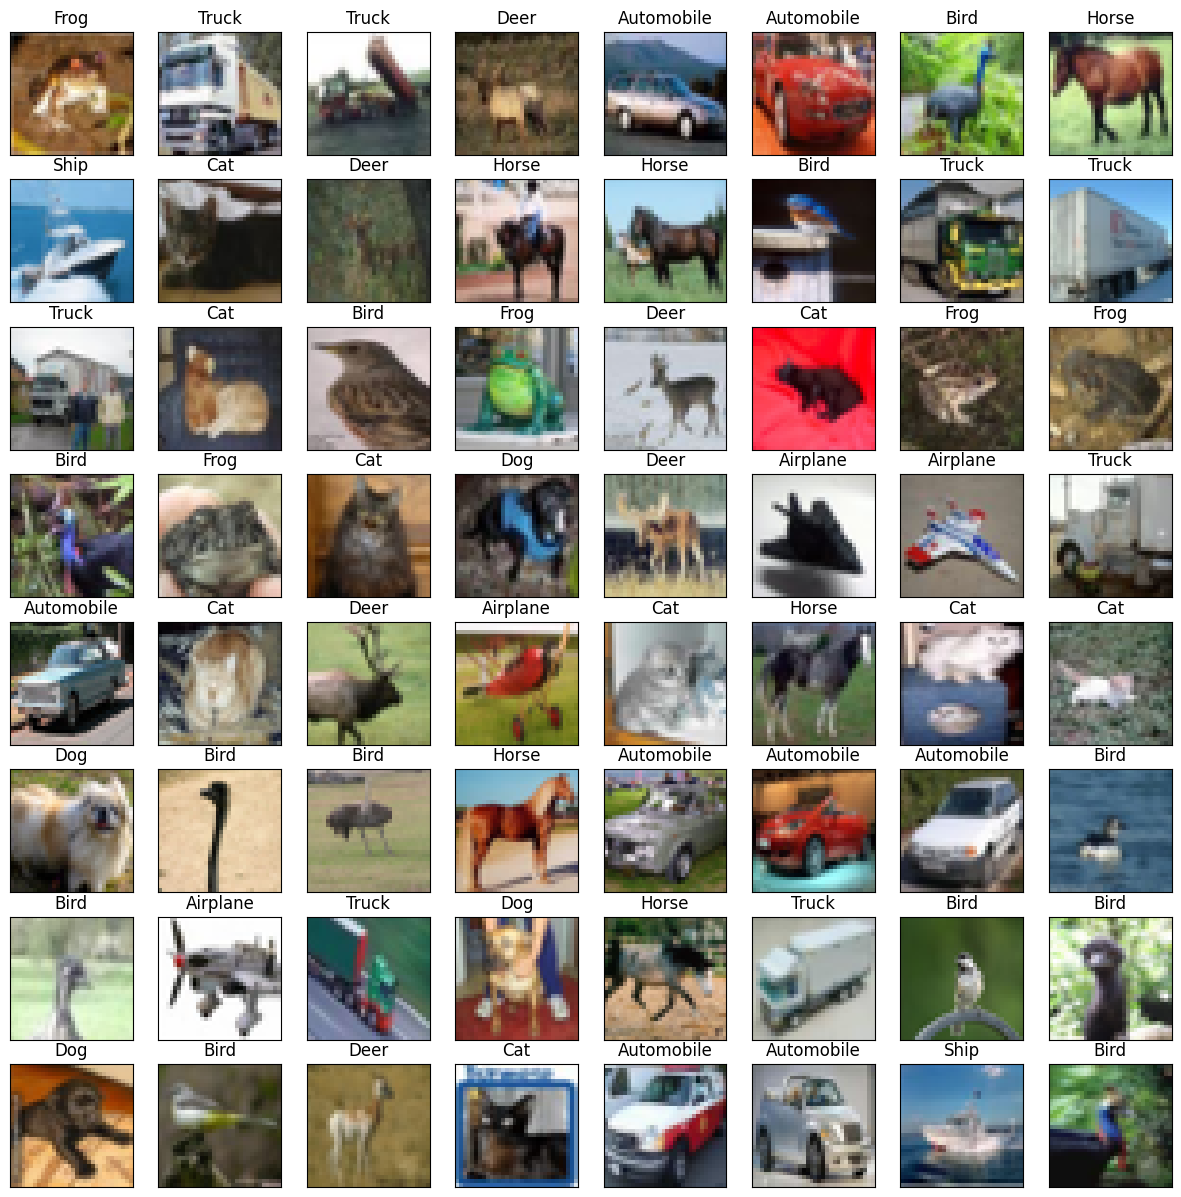

In [4]:
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()



Allocate a validation set to monitor training progress and evaluate model performance on unseen data during training

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)


print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


### Image Data Preprocessing and Transformation

#### Normalization:

In [6]:
# Check the min and max pixel values for training, validation, and test datasets
print("Training:", np.min(X_train), "|", np.max(X_train))
print("Validation:", np.min(X_valid), "|", np.max(X_valid))
print("Test:", np.min(X_test), "|", np.max(X_test))


Training: 0 | 255
Validation: 0 | 255
Test: 0 | 255


In [7]:
# Convert pixel values to float32 to ensure higher precision in calculations during training.
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# Each pixel value is normalized by subtracting the mean of the dataset and then dividing by the standard deviation.
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

# Check the min and max pixel values for training, validation, and test datasets
print("Training:", np.min(X_train), "|", np.max(X_train))
print("Validation:", np.min(X_valid), "|", np.max(X_valid))
print("Test:", np.min(X_test), "|", np.max(X_test))

Training: -1.8818035 | 2.092991
Validation: -1.8818035 | 2.092991
Test: -1.8818035 | 2.092991


Normalization ensures that the input data is on a consistent scale. Pixel values ranging from 1 to 255 are quite large, and without rescaling, the neural network might struggle to learn effectively from the data. By reducing the pixel values to a consistent and smaller range, normalization helps the network learn patterns more efficiently, accelerates convergence, and prevents issues related to large or skewed data ranges.

In [8]:
# Convert the integer labels to a one-hot encoded vector with 10 elements, corresponding to the 10 classes in the dataset.

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

### Model 1: Basic CNN with Regularization

**Model_1** is made up of 3 convolutional blocks, each followed by batch normalization, max pooling, and dropout.

**Batch Normalization (BatchNorm)** is a technique designed to improve the training of neural networks by stabilizing the distributions of layer inputs. It helps neural networks train faster and more reliably by mitigating issues caused by shifting data distributions during training (known as "internal covariate shift"). **Internal covariate shift** occurs when the distribution of activations in intermediate layers changes as the parameters of previous layers are updated; BatchNorm addresses this by normalizing the activations, maintaining a consistent mean and variance across mini-batches.

[![Batch Normalization](https://i.imgur.com/9XiYk6l.png)](https://arxiv.org/pdf/1502.03167)

**Max Pooling** is a downsampling technique that selects the maximum value from a small region of the input. It helps prevent overfitting and enhances the model's ability to generalize.

**Dropout** is another regularization technique that randomly sets a fraction of neurons to zero during training, preventing the model from overfitting by forcing it to learn more robust features and avoid relying on specific neurons.

The number of filters are increased deeper into the network to capture more complex and abstract features. Early layers typically focus on basic patterns such as edges and colors, while deeper layers extract more detailed and high-level information. Additionally, the dropout rate is increased in deeper layers to improve generalization and further reduce the risk of overfitting.

**Kernel Regularization** is another technique used to mitigate overfitting. With L2 regularization, larger weights are penalized in the loss function to discourage the model from relying too heavily on specific features.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Initialize a sequential model and assign it to model_1
model_1 = Sequential()

# Set weight decay value for L2 regularization
weight_decay = 0.0001

# First convolutional block
model_1.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                   input_shape=(32, 32, 3), kernel_regularizer=l2(weight_decay)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.2))

# Second convolutional block
model_1.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.3))

# Third convolutional block
model_1.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.4))

# Fully connected layer
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)))
model_1.add(Dropout(rate=0.5))

# Output layer
model_1.add(Dense(10, activation='softmax'))

# Model summary
model_1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

The model training process is optimized using the ***Adam Optimizer*** with a learning rate of 0.0005. To improve convergence and avoid overfitting, two callbacks are implemented: ReduceLROnPlateau and EarlyStopping. The learning rate will be halved if no validation loss improvement is observed for 10 epochs, and training will stop if no improvement occurs over 20 epochs. This approach helps avoid overtraining and ensures the model doesn't waste time when further improvements are not possible. Training is performed with a batch size of 64 and a maximum of 200 epochs.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import bson

# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 200

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callbackx
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 20 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
history_1 = model_1.fit(X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_valid, y_valid),
            callbacks=[reduce_lr, early_stopping],
            verbose=2)

# Save the model weights to BSON
def save_weights_bson(model, filename):
    weights = model.get_weights()  # Get the model's weights
    weights_dict = {'weights': [w.tolist() for w in weights]}  # Convert to list (for BSON)
    bson_data = bson.dumps(weights_dict)  # Serialize to BSON

    # Save the BSON data to a file
    with open(filename, 'wb') as f:
        f.write(bson_data)
    print(f"Model weights saved to {filename}")

# Call the function to save the model weights to BSON
save_weights_bson(model_1, 'CIFAR10_model_1_weights.bson')


Epoch 1/200
704/704 - 22s - 31ms/step - accuracy: 0.3137 - loss: 1.9473 - val_accuracy: 0.4682 - val_loss: 1.5549 - learning_rate: 5.0000e-04
Epoch 2/200
704/704 - 6s - 8ms/step - accuracy: 0.4390 - loss: 1.5787 - val_accuracy: 0.5404 - val_loss: 1.3453 - learning_rate: 5.0000e-04
Epoch 3/200
704/704 - 6s - 8ms/step - accuracy: 0.4974 - loss: 1.4236 - val_accuracy: 0.5824 - val_loss: 1.2570 - learning_rate: 5.0000e-04
Epoch 4/200
704/704 - 5s - 7ms/step - accuracy: 0.5436 - loss: 1.3112 - val_accuracy: 0.6366 - val_loss: 1.0607 - learning_rate: 5.0000e-04
Epoch 5/200
704/704 - 5s - 8ms/step - accuracy: 0.5831 - loss: 1.2260 - val_accuracy: 0.6548 - val_loss: 1.0300 - learning_rate: 5.0000e-04
Epoch 6/200
704/704 - 5s - 7ms/step - accuracy: 0.6082 - loss: 1.1592 - val_accuracy: 0.6758 - val_loss: 0.9433 - learning_rate: 5.0000e-04
Epoch 7/200
704/704 - 5s - 7ms/step - accuracy: 0.6281 - loss: 1.1113 - val_accuracy: 0.6958 - val_loss: 0.9227 - learning_rate: 5.0000e-04
Epoch 8/200
704/70

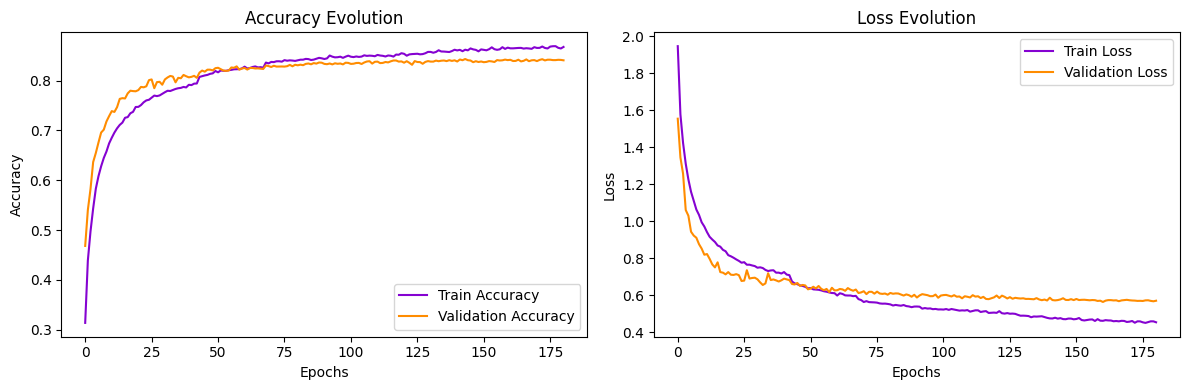

In [ ]:
# Plot accuracy and loss over the epochs

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history_1.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

The training process for the model on the CIFAR-10 dataset has shown promising progress. Initially, both training and validation accuracies steadily increased, with the training loss decreasing as expected. However, after several epochs, a slight divergence between training and validation accuracy was noticed, suggesting potential overfitting. The model has learned well from the data, though further fine-tuning may be necessary to improve generalization as training continues.

In [ ]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model_1.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8495 - loss: 0.5716

Test Accuracy: 0.8478000164031982
Test Loss:     0.5642499327659607


***Model_1*** achieved a test accuracy of 84.78% with a test loss of 0.5642, indicating strong performance and good generalization to unseen data. These results suggest that the model is effectively applying the patterns learned during training to the test set. While the model performs well, further improvements could be made by exploring deeper architectures, more aggressive regularization, or additional techniques to enhance its accuracy and reduce the loss further.

### Model 2: Deep CNN with Regularization and Data Augmentation

In the next model *data augmentation* and *deeper neural networks* will be explored.

***Data augmentation*** refers to the process of artificially increasing the size and diversity of a dataset by applying various transformations to the existing data (e.g. rotations, shifts, or flips). In the context of machine learning, this technique helps prevent overfitting by providing the model with more varied examples during training (Shorten, & Khoshgoftaar, 2019). By enriching the dataset, data augmentation encourages better generalization, enabling the model to learn more robust features.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
data_generator = ImageDataGenerator(
    rotation_range=15,          # Rotate images randomly by up to 15 degrees
    width_shift_range=0.15,     # Shift images horizontally by up to 15% of their width
    height_shift_range=0.15,    # Shift images vertically by up to 15% of their height
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1,             # Zoom images in by up to 10%
    brightness_range=[0.9,1.1], # Change brightness by up to 10%
    shear_range=12,             # Shear intensity (shear angle in counter-clockwise direction in degrees)
    channel_shift_range=0.2,    # Channel shift intensity
)

***Model_2*** incorporates several key changes compared to Model 1 to improve performance. It uses deeper architectures with more layers (256 filters in the later layers compared to 128 filters in Model 1) and employs Global Average Pooling instead of Flatten to reduce computational cost. Additionally, the dropout rate is increased progressively, and L2 regularization is more aggressive, aiming to better control overfitting. Batch normalization is applied after each convolutional block for faster convergence and better generalization. These adjustments collectively aim to enhance model performance by encouraging deeper feature extraction and regularization.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2


# Initialize a sequential model
model_2 = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0005

# First convolutional layer with 32 filters of size 3x3
model_2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                   input_shape=X_train.shape[1:]))
model_2.add(BatchNormalization())

# Second convolutional layer with 32 filters of size 3x3
model_2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.2))

# Third and fourth convolutional layers with 64 filters
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_2.add(BatchNormalization())
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.3))

# Fifth and sixth convolutional layers with 128 filters
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_2.add(BatchNormalization())
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.4))

# Seventh and eighth convolutional layers with 256 filters
model_2.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_2.add(BatchNormalization())
model_2.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.5))

# Global Average Pooling
model_2.add(GlobalAveragePooling2D())

model_2.add(Dense(10, activation='softmax'))

model_2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,178,666 (4.50 MB)

 Trainable params: 1,176,746 (4.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model 2 will utitlize the same training set-up as Model 1.

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import bson

# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 200

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callbackx
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 20 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
history_2 = model_2.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping],
          verbose=2)

# Save the model weights to BSON
def save_weights_bson(model, filename):
    weights = model.get_weights()  # Get the model's weights
    weights_dict = {'weights': [w.tolist() for w in weights]}  # Convert to list (for BSON)
    bson_data = bson.dumps(weights_dict)  # Serialize to BSON

    # Save the BSON data to a file
    with open(filename, 'wb') as f:
        f.write(bson_data)
    print(f"Model weights saved to {filename}")

# Call the function to save the model weights to BSON
save_weights_bson(model_2, 'CIFAR10_model_2_weights.bson')

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 71s - 101ms/step - accuracy: 0.3598 - loss: 2.2733 - val_accuracy: 0.4940 - val_loss: 1.8449 - learning_rate: 5.0000e-04
Epoch 2/200
704/704 - 62s - 88ms/step - accuracy: 0.4981 - loss: 1.7974 - val_accuracy: 0.5446 - val_loss: 1.8287 - learning_rate: 5.0000e-04
Epoch 3/200
704/704 - 82s - 117ms/step - accuracy: 0.5745 - loss: 1.5681 - val_accuracy: 0.6128 - val_loss: 1.5014 - learning_rate: 5.0000e-04
Epoch 4/200
704/704 - 82s - 117ms/step - accuracy: 0.6223 - loss: 1.4148 - val_accuracy: 0.5914 - val_loss: 1.5900 - learning_rate: 5.0000e-04
Epoch 5/200
704/704 - 80s - 114ms/step - accuracy: 0.6567 - loss: 1.3008 - val_accuracy: 0.6694 - val_loss: 1.2825 - learning_rate: 5.0000e-04
Epoch 6/200
704/704 - 83s - 118ms/step - accuracy: 0.6795 - loss: 1.2207 - val_accuracy: 0.7200 - val_loss: 1.1175 - learning_rate: 5.0000e-04
Epoch 7/200
704/704 - 44s - 62ms/step - accuracy: 0.6981 - loss: 1.1596 - val_accuracy: 0.7068 - val_loss: 1.1789 - learning_rate: 5.0000e-04
Epoch 8/200
7

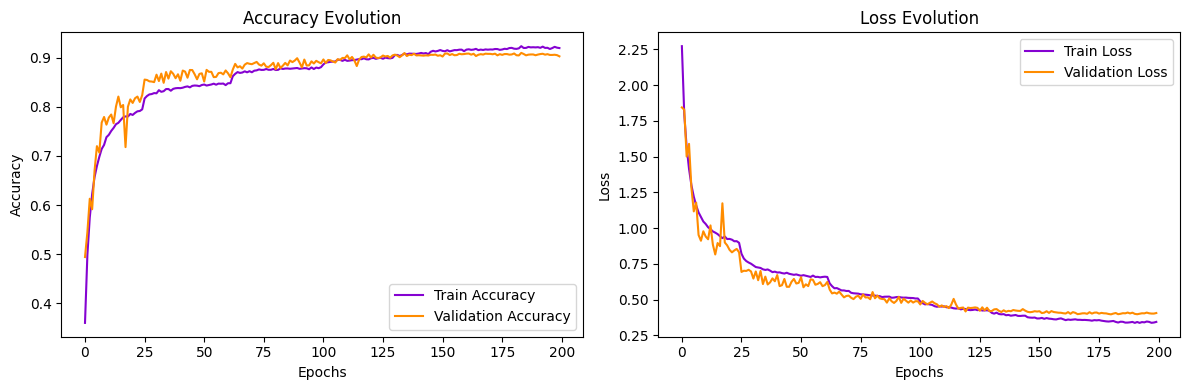

In [13]:
# Plot accuracy and loss over the epochs

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history_2.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

Model_2 shows consistent improvement in validation accuracy over the 200 epochs. Starting with a validation accuracy of about 50% in the first few epochs, it steadily increased, reaching approximately 91% by the final epoch. This indicates the model’s ability to generalize well to unseen data, with validation loss gradually decreasing over time. Despite some fluctuations, the overall trend of improvement in validation accuracy suggests that the model is learning effectively and is well-regularized, avoiding overfitting.

In [14]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9083 - loss: 0.4231

Test Accuracy: 0.9071000218391418
Test Loss:     0.42086294293403625


***Model 2***, which used augmented data and more aggressive regularization, *outperformed Model 1*. With a test accuracy of approximately 90.71% and a test loss of 0.4209, Model 2 significantly improves both in terms of accuracy and loss compared to Model 1, which achieved a test accuracy of about 84.78% and a loss of 0.5642. The enhancements in data augmentation and regularization likely contributed to the model’s better generalization, reducing overfitting and enabling it to perform more effectively on the test set.

### Model 3: Enhanced CNN with Batch Normalization
**Model 3** aims to improve performance on the CIFAR-10 dataset by leveraging Batch Normalization, Dropout, and data augmentation. These techniques are designed to enhance generalization, stabilize training, and reduce overfitting, resulting in a robust model for image classification.


In [ ]:
pip install bson

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import bson

  Preparing metadata (setup.py) ... done
  Created wheel for bson: filename=bson-0.5.10-py3-none-any.whl size=11975 sha256=e0629637c08320081d2db6a53c6e1f39b1037c5e2535f8bb8d6f55b09e958074
  Stored in directory: /root/.cache/pip/wheels/cb/f3/45/c859e83339943dfe2f43e1c9aaebdc00db321191a6fe120947
Successfully built bson


In [15]:
# Load and preprocess CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize pixel values
y_train, y_test = to_categorical(y_train), to_categorical(y_test)  # One-hot encode labels


In [16]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

In [17]:

# Build the model
model_3 = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])


In [18]:
# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Summary of the model
model_3.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 176,298 (688.66 KB)

 Trainable params: 175,658 (686.16 KB)

 Non-trainable params: 640 (2.50 KB)

In [19]:
# Train the model
history_3 = model_3.fit(datagen.flow(X_train, y_train, batch_size=64),
                        validation_data=(X_test, y_test),
                        epochs=50)

# Save the model weights to BSON
def save_weights_bson(model, filename):
    weights = model_3.get_weights()  # Get the model's weights
    weights_dict = {'weights': [w.tolist() for w in weights]}  # Convert to list (for BSON)
    bson_data = bson.dumps(weights_dict)  # Serialize to BSON

    # Save the BSON data to a file
    with open(filename, 'wb') as f:
        f.write(bson_data)
    print(f"Model weights saved to {filename}")

# Call the function to save the model weights to BSON
save_weights_bson(model_3, 'model_3_weights.bson')


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.2840 - loss: 2.0396 - val_accuracy: 0.4215 - val_loss: 1.7471
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 41ms/step - accuracy: 0.4597 - loss: 1.4828 - val_accuracy: 0.5077 - val_loss: 1.4184
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.5298 - loss: 1.3238 - val_accuracy: 0.5535 - val_loss: 1.2542
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.5648 - loss: 1.2322 - val_accuracy: 0.6026 - val_loss: 1.1451
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5947 - loss: 1.1538 - val_accuracy: 0.5356 - val_loss: 1.4881
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6184 - loss: 1.0970 - val_accuracy: 0.6497 - val_loss: 0.9935
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.6325 - loss: 1.0539 - val_accuracy: 0.6435 - val_loss: 1.0474
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6493 - loss: 1.0174 - 

In [20]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model_3.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7876 - loss: 0.6278

Test Accuracy: 0.7883999943733215
Test Loss:     0.6274582147598267


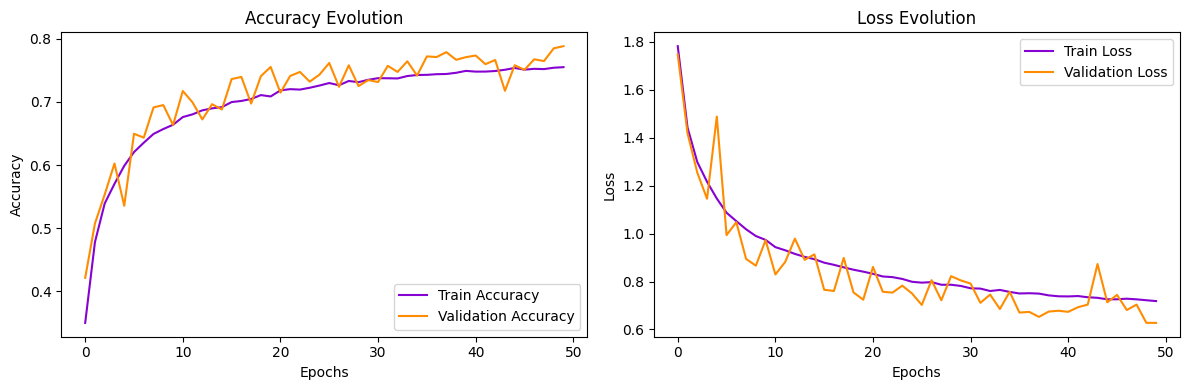

In [21]:
# Plot accuracy and loss over the epochs

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history_3.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

**Model 3** achieved a test accuracy of 78.84% and a loss of 0.6275, showing decent performance with signs of mild overfitting. The training accuracy and loss improved steadily, but validation accuracy was consistently lower, with validation loss showing fluctuations.
Despite being a simpler architecture, the model underperformed compared to the other two, which might indicate that it lacked the capacity to learn complex patterns in the CIFAR-10 dataset.

**Conclusion**
The best model to select is Model 2, as it demonstrates the highest test accuracy (90.71%) and the lowest test loss (0.4209). These metrics indicate that Model 2 effectively generalizes to unseen data while minimizing errors. Its deeper architecture allowed it to learn more complex features, making it the most capable model for the CIFAR-10 dataset in this comparison. Additionally, it outperformed the other models in both validation accuracy and loss during training, further validating its reliability.

**Summary of the Learning Process**

1. Dataset Preparation:
*  Used the CIFAR-10 dataset with 60,000 images (50,000 for training/validation and 10,000 for testing) across 10 classes.
*   Normalized pixel values to have zero mean and unit variance for better training stability.
*   Split data into training, validation, and test sets (80-10-10 split).

2. Model Architectures: Designed and trained three CNN models:
*   Model 1: Three convolutional blocks with Batch Normalization, MaxPooling, Dropout, and Dense layers.
*   Model 2: A deeper model with four convolutional blocks for more complex feature extraction.
*   Model 3: A simpler model with two convolutional blocks.

3. Hyperparameter Tuning:
*   Optimizer: Adam with a learning rate of 0.0005.
*  Batch Size: 64.
*   Loss Function: Categorical Crossentropy.
*   Epochs: Up to 200, with early stopping and learning rate reduction to prevent overfitting.

4. Model Evaluation:
*   Monitored training and validation accuracy/loss during training.
*   Tested models on unseen data to evaluate generalization.

5. Results: ***Model 2*** emerged as the best performer with a test accuracy of 90.77% and the lowest test loss (0.414), showcasing strong generalization and learning capabilities.

### REFERENCES:

Wu, H., Liu, Q., & Liu, X. (2019). *A Review on Deep Learning Approaches to Image Classification and Object Segmentation. Computers*, Materials & Continua (CMC), 60(2), 582. https://doi.org/10.32604/cmc.2019.03595

Krizhevsky, A. (2009). *Learning Multiple Layers of Features from Tiny Images*. University of Toronto. Retrieved from https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

Ioffe, S., & Szegedy, C. (2015). *Batch normalization: Accelerating deep network training by reducing internal covariate shift*. arXiv. https://arxiv.org/pdf/1502.03167

Shorten, C., & Khoshgoftaar, T. M. (2019). *A survey on image data augmentation for deep learning*. Journal of Big Data, 6(1), 60. https://doi.org/10.1186/s40537-019-0197-0


#### SUBMITTED BY:

#### 131120 JOANNA MARIE CORPUZ
#### 131112 THI MINH NGOC DAO